<a href="https://colab.research.google.com/github/AayanHidol/PyTorch/blob/main/PyTorch_02_NN_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Make classification data and get it ready

In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # add little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [3]:
make_circles??

In [4]:
print(f"First 5 X features: \n{X[:5]}")
print(f"\nFirst 5 y labels: \n{y[:5]}")

First 5 X features: 
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels: 
[1 1 1 1 0]


In [5]:
# Make DataFrame of circle data
import pandas as pd # importing pandas which is a popular python library for datascience, aliasing it as pd for ease of typing
circles = pd.DataFrame({"X1": X[:, 0],  # Defining a pandas dataframe with X1, X2, label as the headers
                        "X2": X[:, 1],
                        "label": y})
circles.head(10) # visualizing the first 10 entries in the df


,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [6]:
# Check different labels
circles.label.value_counts()

,count
label,
1,500
0,500


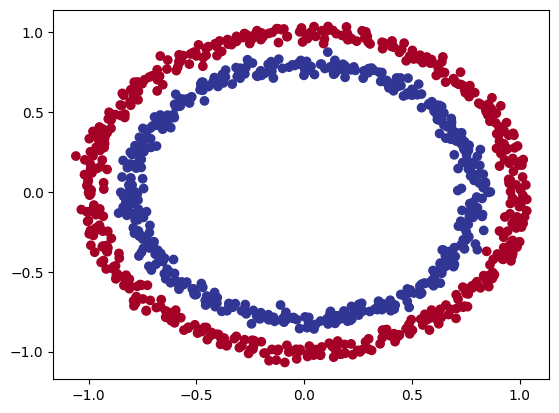

In [7]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 Input and Output shapes

In [8]:
# Check the shape of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
X[0], y[0]

(array([0.75424625, 0.23148074]), np.int64(1))

### 1.2 Turn data into tensors and create train and test splits


In [10]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [12]:
# Split data into train and test splits
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model


In [13]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [14]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  # 3. Define a forward method containing the forward pass computation
  def forward(self, x):
    return self.layer_2(self.layer_1(x))


# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
model_0 = nn.Sequential(nn.Linear(in_features=2, out_features=5),
                        nn.Linear(in_features=5, out_features=1)).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
untrained_preds = model_0(X_test.to(device))

untrained_preds[:5]

tensor([[0.2613],
        [0.3315],
        [0.1197],
        [0.3013],
        [0.1868]], grad_fn=<SliceBackward0>)

### 2.1 Setup loss function and optimizer


In [17]:
loss_fn = nn.BCEWithLogitsLoss() # has sigmoid activation built in
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)


In [18]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

## 3. Train model

### 3.1 Going from raw model outputs to predicted labels
(logits -> prediction probabilities -> prediction labels)


In [19]:
# View the first 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.2613],
        [0.3315],
        [0.1197],
        [0.3013],
        [0.1868]], grad_fn=<SliceBackward0>)

In [20]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5650],
        [0.5821],
        [0.5299],
        [0.5748],
        [0.5466]], grad_fn=<SigmoidBackward0>)

In [21]:
# Find the predicted labels (round the prediction probabilities )
y_preds = torch.round(y_pred_probs)

In [22]:
# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

In [23]:
# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)

### 3.2 Building a training and a testing loop


In [24]:
#Set the manual_seed for reproducibility
torch.manual_seed(42)

#Set the number of epochs
epochs = 100

# Put data on target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Train and eval loop
for epoch in range(epochs):
  ### TRAINING

  # Put model in training mode (default)
  model_0.train()

  # 1. Forward pass (model outputs raw logits)
  y_logits = model_0(X_train).squeeze()
  # can turn y_logits -> pred probs -> pred labels
  y_preds = torch.round(torch.sigmoid(y_logits)) # we need to still do this to feed on to the accuracy_fn which expects the labels

  # 2. Calculate loss/ accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_preds)

  # 3. Zero the accumulated gradients
  optimizer.zero_grad()

  # 4. Calculate the gradients wrt all the parameters
  loss.backward()

  # 5. Take a small gradient descent step
  optimizer.step()

  ### TESTING
  if epoch % 10 == 0:
    # Put model in evaluation mode
    model_0.eval()

    # Turn on inference mode context manager to turn of gradient tracking
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_0(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))

      # 2. Calculate the loss & accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_test, test_pred)

    # Print out what's happening
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.69969, Accuracy: 50.00% | Test Loss: 0.70376, Test acc: 50.00%
Epoch: 10 | Loss: 0.69557, Accuracy: 50.62% | Test Loss: 0.69920, Test acc: 52.50%
Epoch: 20 | Loss: 0.69405, Accuracy: 55.12% | Test Loss: 0.69734, Test acc: 49.50%
Epoch: 30 | Loss: 0.69349, Accuracy: 53.87% | Test Loss: 0.69652, Test acc: 46.00%
Epoch: 40 | Loss: 0.69328, Accuracy: 51.75% | Test Loss: 0.69612, Test acc: 47.00%
Epoch: 50 | Loss: 0.69319, Accuracy: 51.62% | Test Loss: 0.69589, Test acc: 47.00%
Epoch: 60 | Loss: 0.69314, Accuracy: 51.38% | Test Loss: 0.69573, Test acc: 46.50%
Epoch: 70 | Loss: 0.69311, Accuracy: 50.88% | Test Loss: 0.69562, Test acc: 47.50%
Epoch: 80 | Loss: 0.69309, Accuracy: 50.62% | Test Loss: 0.69553, Test acc: 47.50%
Epoch: 90 | Loss: 0.69308, Accuracy: 50.88% | Test Loss: 0.69545, Test acc: 47.50%


## 4. Make predictions and evaluate the model

In [25]:
import numpy as np
# define the plot_decision_boundary() instead of importing from helper_funtions.py
def plot_decision_boundary(model: torch.nn.Module,
                           X: torch.Tensor,
                           y: torch.Tensor):

  # Put everything on CPU (works better with NumPy + Matplotlib)
  model.to("cpu")
  X, y = X.to("cpu"), y.to("cpu")

  # Setup prediction boundaries and grid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

  # Make features
  X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

  # Make predictions
  model.eval()
  with torch.inference_mode():
    y_logits = model(X_to_pred_on)

  # Test for multi-class or binary and adjust logits to prediction labels
  if len(torch.unique(y)) > 2:
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
  else:
    y_pred = torch.round(torch.sigmoid(y_logits))

  # Reshape preds and plot
  y_pred = y_pred.reshape(xx.shape).detach().numpy()
  plt.countourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())




In [26]:
# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


In [27]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [28]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f: # Corrected filename here
    f.write(request.content)

from helper_functions import plot_decision_boundary, plot_predictions

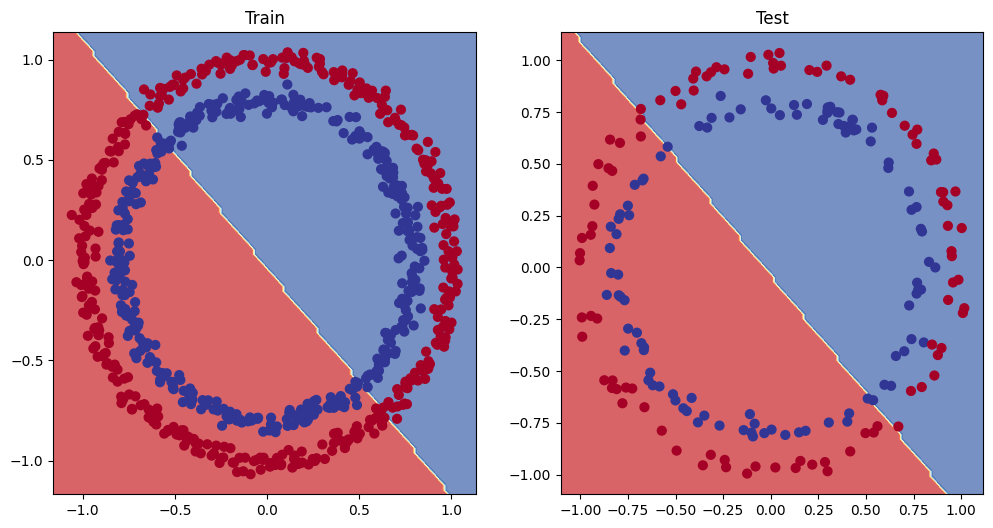

In [29]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

1. Add more layers (make the model more deep)
2. Add more hidden units
3. Fitting for longer (more epochs)
4. Changing the activation functions: some data can't be fit without non-linear activations
5. Changing the learning rate
6. Changing the loss function
7. Use transfer learning

In [30]:
# the code here seemed useless for the revision process so skipping it

## 6. Non-linearity

In [31]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    # interspace the relu activation functions between the layers
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [32]:
# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)

In [33]:
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  # 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate loss and accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_preds)

  # 3. Zero the accumulated gradients
  optimizer.zero_grad()

  # 4. Calculate the gradients wrt parameters
  loss.backward()

  # 5. Take a small gradient descent step
  optimizer.step()

  ### TESTING
  if epoch % 100 == 0:
    # Put model in evaluation mode
    model_3.eval()

    # Turn on inference mode context manager
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_labels = torch.round(torch.sigmoid(test_logits))

      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_test, test_labels)

    # Print out what's happening
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69295, Acc: 50.00% | Test loss: 0.69319, Test Acc: 50.00%
Epoch: 100 | Loss: 0.69115, Acc: 52.88% | Test loss: 0.69102, Test Acc: 52.50%
Epoch: 200 | Loss: 0.68977, Acc: 53.37% | Test loss: 0.68940, Test Acc: 55.00%
Epoch: 300 | Loss: 0.68795, Acc: 53.00% | Test loss: 0.68723, Test Acc: 56.00%
Epoch: 400 | Loss: 0.68517, Acc: 52.75% | Test loss: 0.68411, Test Acc: 56.50%
Epoch: 500 | Loss: 0.68102, Acc: 52.75% | Test loss: 0.67941, Test Acc: 56.50%
Epoch: 600 | Loss: 0.67515, Acc: 54.50% | Test loss: 0.67285, Test Acc: 56.00%
Epoch: 700 | Loss: 0.66659, Acc: 58.38% | Test loss: 0.66322, Test Acc: 59.00%
Epoch: 800 | Loss: 0.65160, Acc: 64.00% | Test loss: 0.64757, Test Acc: 67.50%
Epoch: 900 | Loss: 0.62362, Acc: 74.00% | Test loss: 0.62145, Test Acc: 79.00%


### 6.4 Looking at the predictions


In [34]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

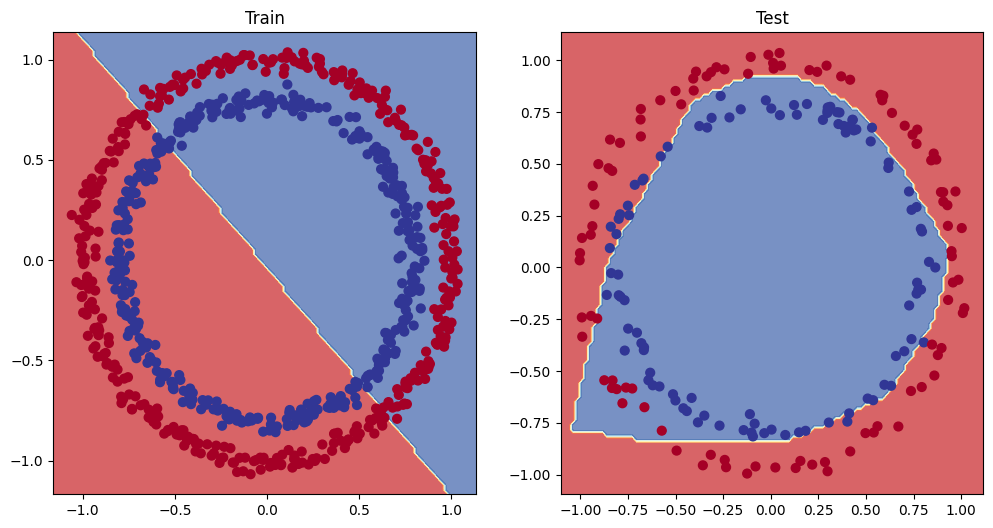

In [35]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

## 8. Multi-Class PyTorch Model

### 8.1 Creating a multi-class classification data


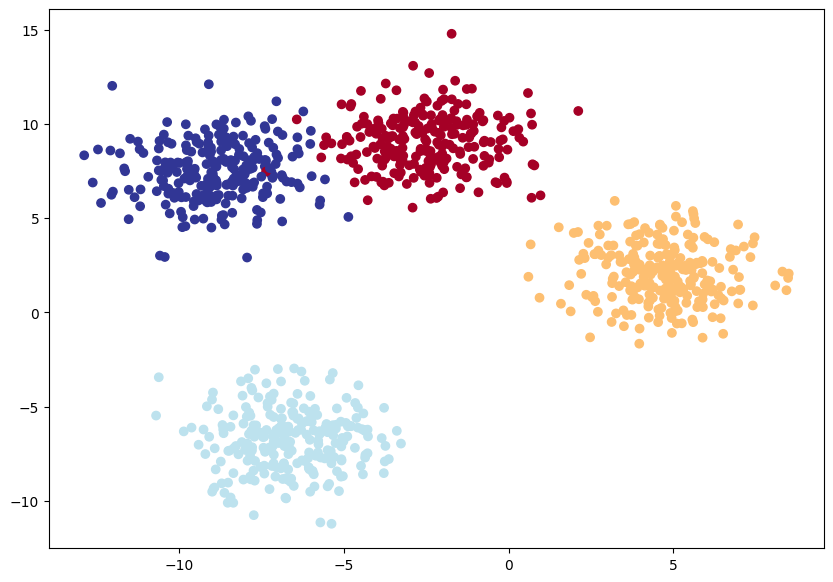

In [46]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5,
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [47]:
X_blob.shape, y_blob.shape

(torch.Size([1000, 2]), torch.Size([1000]))

### 8.2 Building a multi-class classification model in PyTorch

In [48]:
# Create device agnostic code (not needed in the same notebook twice, just adding it here as a reminder)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [49]:
from torch import nn

# Build model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(nn.Linear(in_features=input_features, out_features=hidden_units),
                                             nn.ReLU(), # Instantiate ReLU
                                             nn.Linear(in_features=hidden_units, out_features=hidden_units),
                                             nn.ReLU(), # Instantiate ReLU
                                             nn.Linear(in_features=hidden_units, out_features=output_features))

  def forward(self, x):
    return self.linear_layer_stack(x) # Need to pass the input through the sequential model

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Creating a loss function and optimizer for a multi-class PyTorch model

In [50]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1)

### 8.4 Getting prediction probabilities for a multi-class PyTorch model


In [51]:
model_4(X_blob_train.to(device))[:5]

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2391, -0.2472,  0.1494,  0.0213],
        [-0.1214, -0.9804, -0.6918, -0.1923]], grad_fn=<SliceBackward0>)

In [52]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], grad_fn=<SliceBackward0>)
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], grad_fn=<SliceBackward0>)


In [53]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

tensor(1.0000, grad_fn=<SumBackward0>)

In [54]:
# Which class does the model think is *most* likely at the index 0 sample
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.3169, 0.3244, 0.1405, 0.2182], grad_fn=<SelectBackward0>)
tensor(1)


### 8.5 Creating a training and testing loop for a multiclass pytorch model

In [55]:
# Set the manual seed
torch.manual_seed(42)

epochs = 100

# Put data on target device
X_blob_train = X_blob_train.to(device)
y_blob_train = y_blob_train.to(device)

X_blob_test = X_blob_test.to(device)
y_blob_test = y_blob_test.to(device)


# Loop through all epochs
for epoch in range(epochs):
  ### TRAINING

  # Put model_4 in training mode
  model_4.train()

  # 1. Forward pass
  y_logits = model_4(X_blob_train) # model outputs raw logits
  # go from logits -> prediction probabilities -> prediciton labels
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. Calculate the loss and accuracy
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_blob_train, y_pred)

  # 3. Zero the gradients accumulated in the optimizer
  optimizer.zero_grad()

  # 4. Calculate the gradients wrt each parameter
  loss.backward()

  # 5. Take a small step in the direction of steepest decrease
  optimizer.step()

  ### TESTING at every 10th epoch
  if epoch % 10 == 0:
    # Put model in evaluation mode
    model_4.eval()

    # Use inference context manager
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(X_blob_test, dim=1).argmax(dim=1)

      # 2. Calculate the test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_blob_test, test_pred)

    # Print out what's happening
      print(f"Epoch: {epoch} | Loss: {loss}, Accuracy: {acc}% | Test loss: {test_loss}, Test Acc: {test_acc}%T")

Epoch: 0 | Loss: 1.1588267087936401, Accuracy: 40.375% | Test loss: 1.0755422115325928, Test Acc: 1.5%T
Epoch: 10 | Loss: 0.6447553038597107, Accuracy: 96.75% | Test loss: 0.660687267780304, Test Acc: 1.5%T
Epoch: 20 | Loss: 0.4253515303134918, Accuracy: 98.5% | Test loss: 0.43074119091033936, Test Acc: 1.5%T
Epoch: 30 | Loss: 0.2529422640800476, Accuracy: 99.125% | Test loss: 0.24507610499858856, Test Acc: 1.5%T
Epoch: 40 | Loss: 0.11232147365808487, Accuracy: 99.25% | Test loss: 0.10228512436151505, Test Acc: 1.5%T
Epoch: 50 | Loss: 0.06626509130001068, Accuracy: 99.25% | Test loss: 0.058475371450185776, Test Acc: 1.5%T
Epoch: 60 | Loss: 0.05068016052246094, Accuracy: 99.25% | Test loss: 0.042932283133268356, Test Acc: 1.5%T
Epoch: 70 | Loss: 0.04299675300717354, Accuracy: 99.25% | Test loss: 0.034909654408693314, Test Acc: 1.5%T
Epoch: 80 | Loss: 0.038361385464668274, Accuracy: 99.25% | Test loss: 0.02987821027636528, Test Acc: 1.5%T
Epoch: 90 | Loss: 0.03524842858314514, Accuracy: 

### 8.6 Making and evaluating predicitons with a PyTorch multiclass model

In [56]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# view the first 10 predictons
y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]])

In [60]:
# Turn predicted logits -> prediciton probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities -> prediciton labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(y_preds[:10])
print(y_blob_test[:10])

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])


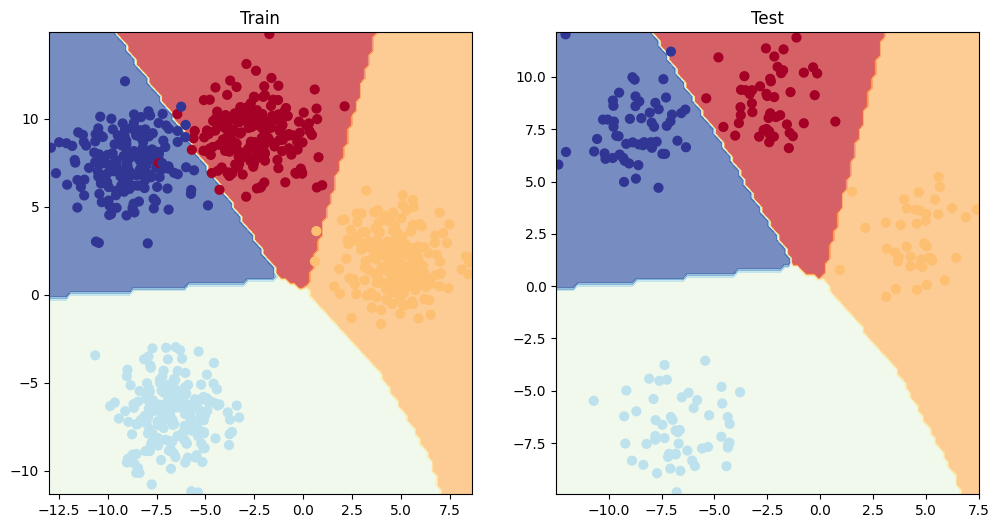

In [61]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. More classification evaluation metrics

In [66]:
try:
  from torchmetrics import Accuracy
except:
  !pip install torchmetrics==0.9.3
  from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
print(f"{torchmetrics_accuracy(y_preds, y_blob_test)*100}%")

99.5%
